# 6.1

In [11]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# =====================================================
# FAZ 6.1 — BASELINE (KIYAS) CSV'LERİ ÜRET
#   Girdi : phase5_routes.csv  (date, vehicle_id, stop_order, Mahalle, latitude, longitude)
#   Çıktı : phase6_comparison_vehicle.csv
#           phase6_comparison_day.csv
#           phase6_baseline_vehicle_summary.csv
# =====================================================

ROUTES_FILE = "phase5_routes.csv"

OUT_VEH = "phase6_comparison_vehicle.csv"
OUT_DAY = "phase6_comparison_day.csv"
OUT_BASE = "phase6_baseline_vehicle_summary.csv"

# -------------------------
# 1) Yardımcılar
# -------------------------
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def route_total_km(points):
    """
    points: list of (lat, lon)
    """
    if len(points) <= 1:
        return 0.0
    total = 0.0
    for i in range(1, len(points)):
        total += haversine_km(points[i-1][0], points[i-1][1], points[i][0], points[i][1])
    return total

def safe_str(x):
    return "" if pd.isna(x) else str(x)

# -------------------------
# 2) Veri oku + temel temizlik
# -------------------------
routes = pd.read_csv(ROUTES_FILE, low_memory=False)

required = {"date","vehicle_id","vehicle_type","stop_order","Mahalle","latitude","longitude"}
missing_cols = sorted(list(required - set(routes.columns)))
if missing_cols:
    raise ValueError(f"{ROUTES_FILE} içinde eksik kolon(lar): {missing_cols}")

# Koordinatlar numeric olsun
routes["latitude"] = pd.to_numeric(routes["latitude"], errors="coerce")
routes["longitude"] = pd.to_numeric(routes["longitude"], errors="coerce")

# Lat/Lon olmayan satırları baseline hesaplarında dışarıda tutacağız.
# (Opt km'yi de aynı satırlardan hesaplamak daha adil.)
routes = routes.dropna(subset=["latitude","longitude"]).copy()

# -------------------------
# 3) Vehicle-Day bazında baseline hesapla
#    Baseline-A: Alfabetik (Mahalle)
#    Baseline-R: Random shuffle ortalaması (N iter)
#    Opt: phase5 stop_order'a göre (zaten optimize rota)
# -------------------------
RANDOM_ITERS = 50
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

vehicle_rows = []

for (date, vehicle_id), g in routes.groupby(["date","vehicle_id"], sort=False):
    g = g.copy()

    vehicle_type = g["vehicle_type"].iloc[0]

    # Opt rota: stop_order'a göre
    g_opt = g.sort_values("stop_order", kind="mergesort")
    opt_points = list(zip(g_opt["latitude"].to_list(), g_opt["longitude"].to_list()))
    opt_km = route_total_km(opt_points)

    # Baseline-A: Alfabetik Mahalle
    g_alpha = g.assign(_m=g["Mahalle"].map(safe_str)).sort_values(["_m","latitude","longitude"], kind="mergesort")
    alpha_points = list(zip(g_alpha["latitude"].to_list(), g_alpha["longitude"].to_list()))
    baseline_alpha_km = route_total_km(alpha_points)

    # Baseline-R: Random ortalama
    idx = g.index.to_numpy()
    if len(idx) <= 1:
        baseline_random_mean_km = 0.0
        baseline_random_p10_km  = 0.0
        baseline_random_p90_km  = 0.0
    else:
        dists = []
        for _ in range(RANDOM_ITERS):
            perm = rng.permutation(idx)
            gg = g.loc[perm]
            pts = list(zip(gg["latitude"].to_list(), gg["longitude"].to_list()))
            dists.append(route_total_km(pts))
        dists = np.array(dists, dtype=float)
        baseline_random_mean_km = float(dists.mean())
        baseline_random_p10_km  = float(np.percentile(dists, 10))
        baseline_random_p90_km  = float(np.percentile(dists, 90))

    stops = int(len(g_opt))

    # Tasarruf metrikleri (pozitif = iyileşme)
    save_alpha_km = baseline_alpha_km - opt_km
    save_rand_km  = baseline_random_mean_km - opt_km

    save_alpha_pct = (save_alpha_km / baseline_alpha_km * 100.0) if baseline_alpha_km > 0 else np.nan
    save_rand_pct  = (save_rand_km  / baseline_random_mean_km * 100.0) if baseline_random_mean_km > 0 else np.nan

    vehicle_rows.append({
        "date": date,
        "vehicle_id": vehicle_id,
        "vehicle_type": vehicle_type,
        "stops_used": stops,

        "opt_km": round(opt_km, 3),

        "baseline_alpha_km": round(baseline_alpha_km, 3),
        "savings_vs_alpha_km": round(save_alpha_km, 3),
        "savings_vs_alpha_pct": round(save_alpha_pct, 2) if pd.notna(save_alpha_pct) else np.nan,

        "baseline_random_mean_km": round(baseline_random_mean_km, 3),
        "baseline_random_p10_km": round(baseline_random_p10_km, 3),
        "baseline_random_p90_km": round(baseline_random_p90_km, 3),
        "savings_vs_random_mean_km": round(save_rand_km, 3),
        "savings_vs_random_mean_pct": round(save_rand_pct, 2) if pd.notna(save_rand_pct) else np.nan,

        "random_iters": RANDOM_ITERS,
        "random_seed": RANDOM_SEED,
    })

veh = pd.DataFrame(vehicle_rows)

# -------------------------
# 4) Günlük özet (date bazında)
# -------------------------
day = (
    veh.groupby("date", as_index=False)
       .agg(
           vehicles=("vehicle_id", "nunique"),
           stops_used=("stops_used", "sum"),

           opt_km=("opt_km", "sum"),
           baseline_alpha_km=("baseline_alpha_km", "sum"),
           baseline_random_mean_km=("baseline_random_mean_km", "sum"),

           savings_vs_alpha_km=("savings_vs_alpha_km", "sum"),
           savings_vs_random_mean_km=("savings_vs_random_mean_km", "sum"),
       )
)

day["savings_vs_alpha_pct"] = np.where(
    day["baseline_alpha_km"] > 0,
    (day["savings_vs_alpha_km"] / day["baseline_alpha_km"]) * 100.0,
    np.nan
)
day["savings_vs_random_mean_pct"] = np.where(
    day["baseline_random_mean_km"] > 0,
    (day["savings_vs_random_mean_km"] / day["baseline_random_mean_km"]) * 100.0,
    np.nan
)

# -------------------------
# 5) Kaydet
# -------------------------
veh.to_csv(OUT_VEH, index=False)
day.to_csv(OUT_DAY, index=False)

# İstersen baseline-only tablo (opt + baseline'lar) ayrı da kalsın
veh[[
    "date","vehicle_id","vehicle_type","stops_used",
    "opt_km","baseline_alpha_km","baseline_random_mean_km",
    "baseline_random_p10_km","baseline_random_p90_km"
]].to_csv(OUT_BASE, index=False)

print("✅ Faz 6.1 tamamlandı.")
print(f"-> {OUT_VEH}")
print(f"-> {OUT_DAY}")
print(f"-> {OUT_BASE}")

# Hızlı kontrol (en çok tasarruf edilen 10 araç-gün)
print("\nTop 10 savings vs alpha (km):")
print(veh.sort_values("savings_vs_alpha_km", ascending=False).head(10)[
    ["date","vehicle_id","vehicle_type","stops_used","opt_km","baseline_alpha_km","savings_vs_alpha_km","savings_vs_alpha_pct"]
])

✅ Faz 6.1 tamamlandı.
-> phase6_comparison_vehicle.csv
-> phase6_comparison_day.csv
-> phase6_baseline_vehicle_summary.csv

Top 10 savings vs alpha (km):
           date  vehicle_id vehicle_type  stops_used  opt_km  \
89   2025-12-20        7924      UNKNOWN          23  34.172   
70   2025-12-20        4257      UNKNOWN          22  28.833   
234  2025-12-24        7924      UNKNOWN          22  31.987   
192  2025-12-23        7924      UNKNOWN          25  29.869   
110  2025-12-21        9279      UNKNOWN           9  23.220   
200  2025-12-24        1434      UNKNOWN          20  17.904   
109  2025-12-21        7924      UNKNOWN          16  28.778   
69   2025-12-20        3615      UNKNOWN          20  33.748   
216  2025-12-24        4257      UNKNOWN          17  23.143   
103  2025-12-21        4257      UNKNOWN          14  22.460   

     baseline_alpha_km  savings_vs_alpha_km  savings_vs_alpha_pct  
89              80.866               46.694                 57.74  
70   

# 6.2

Seçilen örnek (max savings):
date                    2025-12-20
vehicle_id                    7924
vehicle_type               UNKNOWN
stops_used                      23
opt_km                      34.172
baseline_alpha_km           80.866
savings_vs_alpha_km         46.694
savings_vs_alpha_pct         57.74
Name: 89, dtype: object

Hesaplanan km (phase5 noktalardan):
  Baseline(alpha) km: 44.98
  Optimize km      : 34.17
  Tasarruf         : 10.80 km  (%24.02)


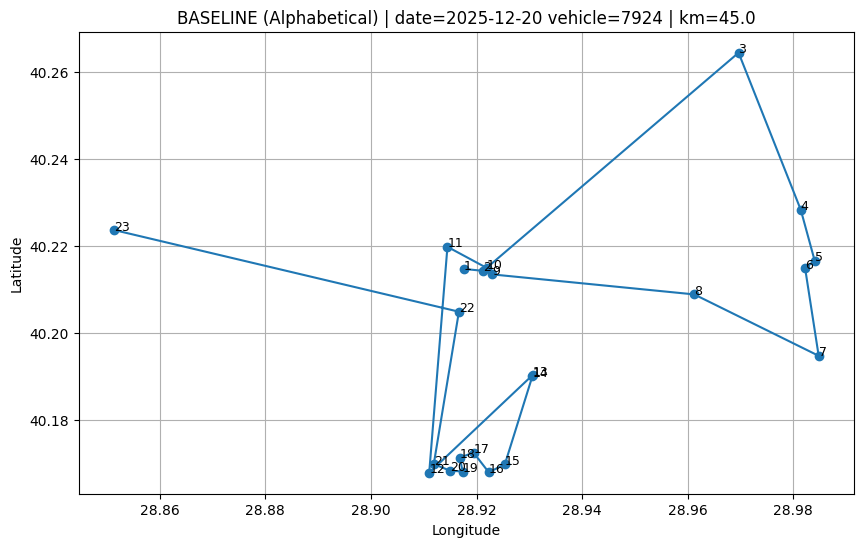

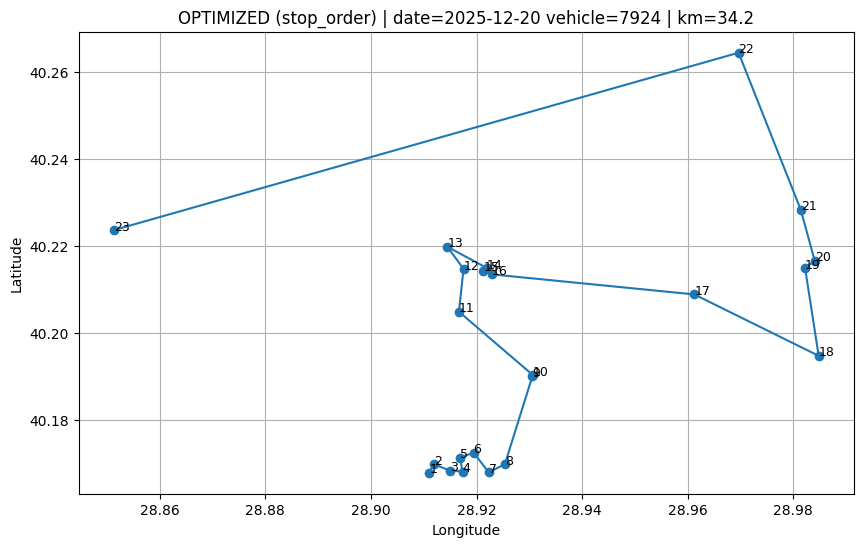

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

# -------------------------
# Mesafe (Haversine)
# -------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

def route_km(df_points):
    """df_points: latitude/longitude sıralı DataFrame"""
    if len(df_points) <= 1:
        return 0.0
    dist = 0.0
    for i in range(1, len(df_points)):
        dist += haversine(
            df_points.iloc[i-1]["latitude"], df_points.iloc[i-1]["longitude"],
            df_points.iloc[i]["latitude"],  df_points.iloc[i]["longitude"]
        )
    return dist

def plot_route(df_points, title):
    """df_points: latitude/longitude sıralı DataFrame"""
    plt.figure(figsize=(10, 6))
    plt.plot(df_points["longitude"], df_points["latitude"], marker="o")
    # stop_order yaz
    for i, r in df_points.reset_index(drop=True).iterrows():
        plt.text(r["longitude"], r["latitude"], str(i+1), fontsize=9)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

# -------------------------
# 1) Dosyaları oku
# -------------------------
routes = pd.read_csv("phase5_routes.csv")
comp  = pd.read_csv("phase6_comparison_vehicle.csv")

# Tip düzeltmeleri (güvenli)
# date bazen string gelir; sadece eşleştirmede kullanacağız
routes["date"] = routes["date"].astype(str)
comp["date"]   = comp["date"].astype(str)

# -------------------------
# 2) En çok tasarruf edilen gün+araç seç
# -------------------------
top = comp.sort_values("savings_vs_alpha_km", ascending=False).iloc[0]
target_date = str(top["date"])
target_vehicle = int(top["vehicle_id"])

print("Seçilen örnek (max savings):")
print(top[["date","vehicle_id","vehicle_type","stops_used","opt_km","baseline_alpha_km","savings_vs_alpha_km","savings_vs_alpha_pct"]])

# -------------------------
# 3) O gün+araç için faz5 duraklarını çek
# -------------------------
sel = routes[(routes["date"].astype(str) == target_date) & (routes["vehicle_id"] == target_vehicle)].copy()

# Kritik: latitude/longitude boşsa rota çizilemez
sel = sel.dropna(subset=["latitude", "longitude"])

if sel.empty:
    raise ValueError("Seçilen gün+araç için phase5_routes.csv içinde latitude/longitude dolu kayıt bulunamadı.")

# -------------------------
# 4) Optimize rota (stop_order) ve baseline rota (alfabetik Mahalle)
# -------------------------
opt_route = sel.sort_values("stop_order")[["Mahalle","latitude","longitude"]].reset_index(drop=True)

# Aynı noktalar, alfabetik Mahalle = alpha baseline mantığı
base_route = sel.sort_values("Mahalle")[["Mahalle","latitude","longitude"]].reset_index(drop=True)

opt_km_calc  = route_km(opt_route)
base_km_calc = route_km(base_route)

print(f"\nHesaplanan km (phase5 noktalardan):")
print(f"  Baseline(alpha) km: {base_km_calc:.2f}")
print(f"  Optimize km      : {opt_km_calc:.2f}")
if base_km_calc > 0:
    print(f"  Tasarruf         : {base_km_calc - opt_km_calc:.2f} km  (%{(base_km_calc - opt_km_calc)/base_km_calc*100:.2f})")

# -------------------------
# 5) Çizimler (iki ayrı figür)
# -------------------------
plot_route(
    base_route,
    f"BASELINE (Alphabetical) | date={target_date} vehicle={target_vehicle} | km={base_km_calc:.1f}"
)

plot_route(
    opt_route,
    f"OPTIMIZED (stop_order) | date={target_date} vehicle={target_vehicle} | km={opt_km_calc:.1f}"
)

# 6.3

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# Faz 6.3 — Yakıt & CO2 Etkisi (FIX)
# Girdi :
#   - phase6_comparison_day.csv        (vehicle_type YOK)
#   - phase6_comparison_vehicle.csv    (vehicle_type VAR)
# Çıktı :
#   - phase6_co2_day.csv
#   - phase6_co2_vehicle.csv (varsa)
#   - phase6_co2_summary.csv
# =========================

BASE_DIR = Path(".")
IN_DAY = BASE_DIR / "phase6_comparison_day.csv"
IN_VEH = BASE_DIR / "phase6_comparison_vehicle.csv"

OUT_DAY = BASE_DIR / "phase6_co2_day.csv"
OUT_VEH = BASE_DIR / "phase6_co2_vehicle.csv"
OUT_SUM = BASE_DIR / "phase6_co2_summary.csv"

# -------------------------
# Varsayımlar
# -------------------------
DIESEL_CO2_KG_PER_L = 2.68

# Day-level için tek bir ortalama tüketim (L/km)
# (Bursa belediye çöp toplama için muhafazakar: 0.38-0.45 bandı; default 0.40)
DAY_DEFAULT_L_PER_KM = 0.40

# Vehicle-level için tip bazlı tüketim (L/km)
DEFAULT_L_PER_KM = 0.40
L_PER_KM_BY_TYPE = {
    "Large Garbage Truck": 0.40,
    "Medium Garbage Truck": 0.32,
    "Small Garbage Truck": 0.25,
}

# -------------------------
# Yardımcılar
# -------------------------
def ensure_columns(df: pd.DataFrame, required: list, name: str):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(
            f"{name} içinde eksik kolon(lar): {missing}\nMevcut kolonlar: {list(df.columns)}"
        )

def pick_l_per_km(vehicle_type: str) -> float:
    vt = str(vehicle_type).strip()
    return float(L_PER_KM_BY_TYPE.get(vt, DEFAULT_L_PER_KM))

def compute_saved_km(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["saved_km"] = df["baseline_alpha_km"] - df["opt_km"]
    df["saved_km"] = df["saved_km"].fillna(0.0)
    df.loc[df["saved_km"] < 0, "saved_km"] = 0.0
    return df

# -------------------------
# 1) DAY bazlı CO2 (vehicle_type yok)
# -------------------------
day_df = pd.read_csv(IN_DAY)
ensure_columns(day_df, ["date", "opt_km", "baseline_alpha_km"], "phase6_comparison_day.csv")

day_df = compute_saved_km(day_df)

day_df["l_per_km"] = DAY_DEFAULT_L_PER_KM
day_df["fuel_saved_liters"] = day_df["saved_km"] * day_df["l_per_km"]
day_df["co2_saved_kg"] = day_df["fuel_saved_liters"] * DIESEL_CO2_KG_PER_L
day_df["co2_saved_ton"] = day_df["co2_saved_kg"] / 1000.0

# rapor dostu yuvarlama
for c in ["opt_km", "baseline_alpha_km", "saved_km", "l_per_km", "fuel_saved_liters", "co2_saved_kg"]:
    day_df[c] = day_df[c].round(3)
day_df["co2_saved_ton"] = day_df["co2_saved_ton"].round(6)

day_df.to_csv(OUT_DAY, index=False)

# -------------------------
# 2) VEHICLE bazlı CO2 (vehicle_type var)
# -------------------------
veh_out_written = False
veh_df = None

if IN_VEH.exists():
    veh_df = pd.read_csv(IN_VEH)
    ensure_columns(veh_df, ["date", "vehicle_id", "vehicle_type", "opt_km", "baseline_alpha_km"], "phase6_comparison_vehicle.csv")

    veh_df = compute_saved_km(veh_df)

    veh_df["l_per_km"] = veh_df["vehicle_type"].apply(pick_l_per_km)
    veh_df["fuel_saved_liters"] = veh_df["saved_km"] * veh_df["l_per_km"]
    veh_df["co2_saved_kg"] = veh_df["fuel_saved_liters"] * DIESEL_CO2_KG_PER_L
    veh_df["co2_saved_ton"] = veh_df["co2_saved_kg"] / 1000.0

    for c in ["opt_km", "baseline_alpha_km", "saved_km", "l_per_km", "fuel_saved_liters", "co2_saved_kg"]:
        veh_df[c] = veh_df[c].round(3)
    veh_df["co2_saved_ton"] = veh_df["co2_saved_ton"].round(6)

    veh_df.to_csv(OUT_VEH, index=False)
    veh_out_written = True

# -------------------------
# 3) Özet CSV
# -------------------------
summary_rows = []

# Day totals
total_saved_km = float(day_df["saved_km"].sum())
total_fuel = float(day_df["fuel_saved_liters"].sum())
total_co2_kg = float(day_df["co2_saved_kg"].sum())
total_co2_ton = float(day_df["co2_saved_ton"].sum())

summary_rows.append({
    "scope": "ALL_DAYS_TOTAL_FROM_DAYCSV",
    "saved_km": round(total_saved_km, 3),
    "fuel_saved_liters": round(total_fuel, 3),
    "co2_saved_kg": round(total_co2_kg, 3),
    "co2_saved_ton": round(total_co2_ton, 6),
    "diesel_co2_kg_per_l": DIESEL_CO2_KG_PER_L,
    "day_default_l_per_km": DAY_DEFAULT_L_PER_KM,
})

# Vehicle totals + type breakdown (daha doğruysa)
if veh_out_written and veh_df is not None:
    v_total_saved_km = float(veh_df["saved_km"].sum())
    v_total_fuel = float(veh_df["fuel_saved_liters"].sum())
    v_total_co2_kg = float(veh_df["co2_saved_kg"].sum())
    v_total_co2_ton = float(veh_df["co2_saved_ton"].sum())

    summary_rows.append({
        "scope": "ALL_DAYS_TOTAL_FROM_VEHICLECSV",
        "saved_km": round(v_total_saved_km, 3),
        "fuel_saved_liters": round(v_total_fuel, 3),
        "co2_saved_kg": round(v_total_co2_kg, 3),
        "co2_saved_ton": round(v_total_co2_ton, 6),
        "diesel_co2_kg_per_l": DIESEL_CO2_KG_PER_L,
        "default_l_per_km_if_unknown": DEFAULT_L_PER_KM,
    })

    by_type = (
        veh_df.groupby("vehicle_type", dropna=False)[["saved_km", "fuel_saved_liters", "co2_saved_kg", "co2_saved_ton"]]
        .sum()
        .reset_index()
    )
    for _, r in by_type.iterrows():
        summary_rows.append({
            "scope": f"BY_TYPE:{r['vehicle_type']}",
            "saved_km": round(float(r["saved_km"]), 3),
            "fuel_saved_liters": round(float(r["fuel_saved_liters"]), 3),
            "co2_saved_kg": round(float(r["co2_saved_kg"]), 3),
            "co2_saved_ton": round(float(r["co2_saved_ton"]), 6),
            "diesel_co2_kg_per_l": DIESEL_CO2_KG_PER_L,
        })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(OUT_SUM, index=False)

# -------------------------
# 4) Konsol çıktısı
# -------------------------
print("✅ Faz 6.3 tamamlandı.")
print(f"-> {OUT_DAY.name}")
if veh_out_written:
    print(f"-> {OUT_VEH.name}")
print(f"-> {OUT_SUM.name}")

print("\n--- Day CSV bazlı toplam (tek L/km varsayımı) ---")
print(f"Toplam km tasarrufu     : {total_saved_km:,.3f} km")
print(f"Toplam yakıt tasarrufu  : {total_fuel:,.3f} L (L/km={DAY_DEFAULT_L_PER_KM})")
print(f"Toplam CO2 tasarrufu    : {total_co2_kg:,.3f} kg (~{total_co2_ton:,.3f} ton)")

if veh_out_written and veh_df is not None:
    print("\n--- Vehicle CSV bazlı toplam (tip bazlı L/km) ---")
    print(f"Toplam km tasarrufu     : {v_total_saved_km:,.3f} km")
    print(f"Toplam yakıt tasarrufu  : {v_total_fuel:,.3f} L")
    print(f"Toplam CO2 tasarrufu    : {v_total_co2_kg:,.3f} kg (~{v_total_co2_ton:,.3f} ton)")
    print("\nTip bazlı tüketimler (L/km):")
    print(L_PER_KM_BY_TYPE)


✅ Faz 6.3 tamamlandı.
-> phase6_co2_day.csv
-> phase6_co2_vehicle.csv
-> phase6_co2_summary.csv

--- Day CSV bazlı toplam (tek L/km varsayımı) ---
Toplam km tasarrufu     : 997.630 km
Toplam yakıt tasarrufu  : 399.052 L (L/km=0.4)
Toplam CO2 tasarrufu    : 1,069.460 kg (~1.069 ton)

--- Vehicle CSV bazlı toplam (tip bazlı L/km) ---
Toplam km tasarrufu     : 1,006.037 km
Toplam yakıt tasarrufu  : 402.417 L
Toplam CO2 tasarrufu    : 1,078.482 kg (~1.078 ton)

Tip bazlı tüketimler (L/km):
{'Large Garbage Truck': 0.4, 'Medium Garbage Truck': 0.32, 'Small Garbage Truck': 0.25}


# 6.4

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# Faz 6.4 — Görselleştirme
# =========================

BASE_DIR = Path(".")
DAY_FILE = BASE_DIR / "phase6_co2_day.csv"
VEH_FILE = BASE_DIR / "phase6_co2_vehicle.csv"

OUT1 = BASE_DIR / "fig_day_co2_bar.png"
OUT2 = BASE_DIR / "fig_cumulative_co2.png"
OUT3 = BASE_DIR / "fig_top10_vehicle_co2.png"

# -------------------------
# 1) Günlük CO2 Tasarrufu (Bar)
# -------------------------
day_df = pd.read_csv(DAY_FILE)
day_df["date"] = pd.to_datetime(day_df["date"])
day_df = day_df.sort_values("date")

plt.figure(figsize=(10, 5))
plt.bar(day_df["date"].dt.strftime("%Y-%m-%d"),
        day_df["co2_saved_kg"] / 1000.0)
plt.ylabel("CO₂ Tasarrufu (ton)")
plt.xlabel("Tarih")
plt.title("Günlük CO₂ Tasarrufu (GreenRoute)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT1, dpi=200)
plt.close()

# -------------------------
# 2) Kümülatif CO2 Tasarrufu (Line)
# -------------------------
day_df["cumulative_co2_ton"] = (day_df["co2_saved_kg"] / 1000.0).cumsum()

plt.figure(figsize=(10, 5))
plt.plot(day_df["date"].dt.strftime("%Y-%m-%d"),
         day_df["cumulative_co2_ton"],
         marker="o")
plt.ylabel("Kümülatif CO₂ Tasarrufu (ton)")
plt.xlabel("Tarih")
plt.title("Kümülatif CO₂ Tasarrufu (Pilot Süreç)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT2, dpi=200)
plt.close()

# -------------------------
# 3) En Çok CO2 Tasarrufu Yapan Top 10 Araç
# -------------------------
veh_df = pd.read_csv(VEH_FILE)

top10 = (
    veh_df.groupby("vehicle_id")[["co2_saved_kg"]]
    .sum()
    .reset_index()
    .sort_values("co2_saved_kg", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
plt.bar(top10["vehicle_id"].astype(str),
        top10["co2_saved_kg"] / 1000.0)
plt.ylabel("Toplam CO₂ Tasarrufu (ton)")
plt.xlabel("Araç ID")
plt.title("En Fazla CO₂ Tasarrufu Sağlayan İlk 10 Araç")
plt.tight_layout()
plt.savefig(OUT3, dpi=200)
plt.close()

print("✅ Faz 6.4 tamamlandı.")
print("Oluşturulan grafikler:")
print(f"- {OUT1.name}")
print(f"- {OUT2.name}")
print(f"- {OUT3.name}")


✅ Faz 6.4 tamamlandı.
Oluşturulan grafikler:
- fig_day_co2_bar.png
- fig_cumulative_co2.png
- fig_top10_vehicle_co2.png
